In [1]:
# ahora vamos a graficas con una de las fuentes de datos
#importo la libreria
from pyspark.sql import SparkSession

#abro una sesion con un nombre
#spark=SparkSession.builder.appName('pysarkpruebas').getOrCreate()
spark = SparkSession\
.builder\
.config("spark.submit.deployMode", "client")\
.config("spark.executor.instances", "4")\
.config("spark.executor.memory", "5g")\
.config("spark.driver.memory", "10g")\
.config("spark.executor.memoryOverhead", "10g")\
.appName("Application Name")\
.getOrCreate()


#leo movie
df_movie = spark.read.csv('hdfs://127.0.0.1:9000/cursoFAI/movie.csv', header=True, inferSchema=True)
#leo rating
df_rating = spark.read.csv('hdfs://127.0.0.1:9000/cursoFAI/rating.csv', header=True,  inferSchema=True)

spark.sparkContext._conf.getAll()  # check the config

[('spark.executor.instances', '4'),
 ('spark.driver.memory', '10g'),
 ('spark.sql.warehouse.dir',
  'file:/home/usuarioFAI/ejemplosPython/spark-warehouse'),
 ('spark.executor.id', 'driver'),
 ('spark.app.id', 'local-1620674452376'),
 ('spark.executor.memory', '5g'),
 ('spark.driver.port', '43246'),
 ('spark.driver.host', '192.168.1.164'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Application Name'),
 ('spark.app.startTime', '1620674450172'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.executor.memoryOverhead', '10g'),
 ('spark.ui.showConsoleProgress', 'true')]

In [2]:
df_rating.count()

20000263

In [3]:
df_rating.show(5)


+------+-------+------+-------------------+
|userId|movieId|rating|          timestamp|
+------+-------+------+-------------------+
|     1|      2|   3.5|2005-04-02 23:53:47|
|     1|     29|   3.5|2005-04-02 23:31:16|
|     1|     32|   3.5|2005-04-02 23:33:39|
|     1|     47|   3.5|2005-04-02 23:32:07|
|     1|     50|   3.5|2005-04-02 23:29:40|
+------+-------+------+-------------------+
only showing top 5 rows



In [4]:
df_movie.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [5]:
# quiero mirar el rating de una pelicula en particular.
#me quedo solo con los movies 1
df_rating1 = df_rating.filter(df_rating['movieId'] == 1)

df_rating1.count()

49695

In [6]:
#para probar hago un join... igualmente va a repetir todos los las de la movie 1 siempre
joinmoviesrating = df_rating1.join(df_movie,df_rating1.movieId ==  df_movie.movieId,"inner")     

joinmoviesrating.show(truncate=False)




+------+-------+------+-------------------+-------+----------------+-------------------------------------------+
|userId|movieId|rating|timestamp          |movieId|title           |genres                                     |
+------+-------+------+-------------------+-------+----------------+-------------------------------------------+
|3     |1      |4.0   |1999-12-11 13:36:47|1      |Toy Story (1995)|Adventure|Animation|Children|Comedy|Fantasy|
|6     |1      |5.0   |1997-03-13 17:50:52|1      |Toy Story (1995)|Adventure|Animation|Children|Comedy|Fantasy|
|8     |1      |4.0   |1996-06-05 13:37:51|1      |Toy Story (1995)|Adventure|Animation|Children|Comedy|Fantasy|
|10    |1      |4.0   |1999-11-25 02:44:47|1      |Toy Story (1995)|Adventure|Animation|Children|Comedy|Fantasy|
|11    |1      |4.5   |2009-01-02 01:13:41|1      |Toy Story (1995)|Adventure|Animation|Children|Comedy|Fantasy|
|12    |1      |4.0   |1997-03-22 20:48:38|1      |Toy Story (1995)|Adventure|Animation|Children

In [7]:
#tengo valores nulos?

joinmoviesrating.filter(joinmoviesrating['rating'].isNull()).count()


0

In [8]:
# creo una serie con los datos de rating para la movie 1
# para saber ctos días se mantuvo con el mismo rating
import pandas as pd


pdf_joinmoviesrating = joinmoviesrating.toPandas()
#cantidad de valores diferentes de la columna timestamp...
pdf_joinmoviesrating['timestamp'].nunique()

49684

In [9]:
#como son todos diferentes me quedo solo con la fecha del timestamp...


pdf_joinmoviesrating['Datetime'] = pdf_joinmoviesrating['timestamp'].astype('datetime64[ns]')
pdf_joinmoviesrating.info()


pdf_joinmoviesrating['fecha'] = pdf_joinmoviesrating['Datetime'].dt.date

pdf_joinmoviesrating.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49695 entries, 0 to 49694
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   userId     49695 non-null  int32         
 1   movieId    49695 non-null  int32         
 2   rating     49695 non-null  float64       
 3   timestamp  49695 non-null  object        
 4   movieId    49695 non-null  int32         
 5   title      49695 non-null  object        
 6   genres     49695 non-null  object        
 7   Datetime   49695 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int32(3), object(3)
memory usage: 2.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49695 entries, 0 to 49694
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   userId     49695 non-null  int32         
 1   movieId    49695 non-null  int32         
 2   rating     49695 non-null  float64      

In [10]:
#veo ctas fechas diferentes hay
pdf_joinmoviesrating['fecha'].nunique()

6519

In [39]:
# ahora se puedo agrupar por fecha y ver lo ratings de la movie 1

#primero me quedo con fecha y rating

pdf_joinmoviesrating1 = pdf_joinmoviesrating[['rating', 'fecha']]

pdf_joinmoviesrating1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49695 entries, 0 to 49694
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rating  49695 non-null  float64
 1   fecha   49695 non-null  object 
dtypes: float64(1), object(1)
memory usage: 776.6+ KB


In [12]:

#calculo para cada fecha el promedio de ratings
pdf_joinmoviesrating2 = pdf_joinmoviesrating1.groupby(['fecha']).agg(['mean'])
pdf_joinmoviesrating2


,rating
,mean
fecha,
1996-01-29,4.000000
1996-02-01,5.000000
1996-02-02,4.500000
1996-02-05,5.000000
1996-02-12,5.000000
...,...
2015-03-26,4.500000
2015-03-27,3.750000


In [13]:
# lo paso a serie de pandas
ser1 = pd.Series(pdf_joinmoviesrating2.iloc[:,0])


print('La serie es: \n',  ser1)

La serie es: 
 fecha
1996-01-29    4.000000
1996-02-01    5.000000
1996-02-02    4.500000
1996-02-05    5.000000
1996-02-12    5.000000
                ...   
2015-03-26    4.500000
2015-03-27    3.750000
2015-03-28    3.500000
2015-03-29    3.916667
2015-03-30    3.875000
Name: (rating, mean), Length: 6519, dtype: float64


In [14]:
#ahora, me quedo con una cantidad aleatoria, una muestra
#seleccionar un conjunto de filas como muestra
ser2 = ser1.sample(frac=0.1).sort_index()

print('La serie es: \n',  ser2)


La serie es: 
 fecha
1996-03-12    5.000000
1996-04-02    4.923077
1996-04-09    4.769231
1996-04-23    4.000000
1996-04-26    4.407407
                ...   
2015-03-05    4.035714
2015-03-07    4.000000
2015-03-18    4.250000
2015-03-19    3.750000
2015-03-30    3.875000
Name: (rating, mean), Length: 652, dtype: float64


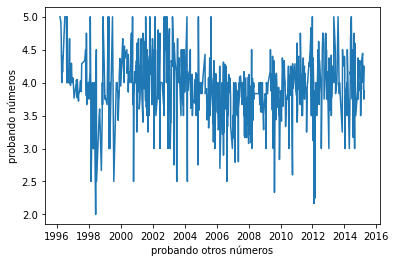

In [15]:
import matplotlib.pyplot as plt


plt.plot(ser2)
plt.ylabel('probando números')
plt.xlabel('probando otros números')
plt.show()

In [48]:
# como son un monton de datos podemos agruparlos también por año, por ejemplo... y graficar desde ahi..

pdf_joinmoviesrating1 = pdf_joinmoviesrating[['rating', 'fecha']]


pdf_joinmoviesrating1.info()

pdf_joinmoviesrating1['año'] = pd.DatetimeIndex(pdf_joinmoviesrating1['fecha']).year

pdf_joinmoviesrating1.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49695 entries, 0 to 49694
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rating  49695 non-null  float64
 1   fecha   49695 non-null  object 
dtypes: float64(1), object(1)
memory usage: 776.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49695 entries, 0 to 49694
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rating  49695 non-null  float64
 1   fecha   49695 non-null  object 
 2   año     49695 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ MB


<ipython-input-48-4dd0ab4646db>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf_joinmoviesrating1['año'] = pd.DatetimeIndex(pdf_joinmoviesrating1['fecha']).year


In [38]:
pdf_joinmoviesrating1.head()

,rating,fecha,year
0,4.0,1999-12-11,1999
1,5.0,1997-03-13,1997
2,4.0,1996-06-05,1996
3,4.0,1999-11-25,1999
4,4.5,2009-01-02,2009


In [49]:
pdf_joinmoviesrating3 = pdf_joinmoviesrating1[['rating', 'año']]

#pdf_joinmoviesrating3.head()
pdf_joinmoviesrating3.count()

rating    49695
año       49695
dtype: int64

In [50]:
# agrupo por año y calculo el promedio


pdf_joinmoviesrating3 = pdf_joinmoviesrating3.groupby(['año']).agg(['mean'])
pdf_joinmoviesrating3.head()


,rating
,mean
año,
1996,4.132270
1997,3.875424
1998,3.885799
1999,3.974688
2000,4.142609


In [53]:
pdf_joinmoviesrating3


,rating
,mean
año,
1996,4.132270
1997,3.875424
1998,3.885799
1999,3.974688
2000,4.142609
2001,4.117698
2002,4.047855
2003,4.004680


In [67]:

# lo paso a serie de pandas
ser1 = pd.Series(pdf_joinmoviesrating3.iloc[:,0])
print('La serie es: \n',  ser1)


La serie es: 
 año
1996    4.132270
1997    3.875424
1998    3.885799
1999    3.974688
2000    4.142609
2001    4.117698
2002    4.047855
2003    4.004680
2004    3.863380
2005    3.755229
2006    3.680774
2007    3.672973
2008    3.740781
2009    3.766777
2010    3.856772
2011    3.861689
2012    3.931421
2013    3.946274
2014    3.954945
2015    3.860412
Name: (rating, mean), dtype: float64


<AxesSubplot:xlabel='año'>

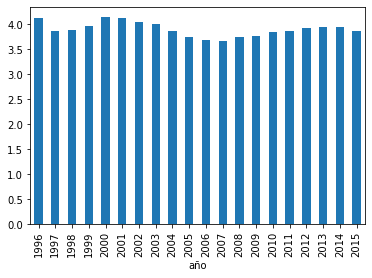

In [68]:
# ahora lo garfico desde pandas
ser1.plot.bar()